# Echo state network on Lorenz and Sin dataset

Author: Daniel Mai 

## Project specification

Implement a standard echo state network (ESN) model. Do not include feedback from the output and do not use leaky-integrator neurons. Implement training of the read-out weights by means of ridge regression. Perform experiments and comment the results by considering a _k_ step ahead forecasting task on the "2sine" and "lorentz" time series data provided to you together with this notebook. Evaluate the impact of relevant hyper-parameters on the results, including the reservoir size and the amount of training data used for optimizing the read-out weights. Finally, discuss the effects of using different forecasting horizons on the overall performance of the model. **Note:** it is possible to consider the impact of additional hyperparameters, like the spectral radius of the reservoir matrix, and this will give you some extra points.

### K step ahead forecasting
A _k_ step ahead forecasting task consists of predicting the value of a time series at time $t+k$ by using the value of the time series at time $t$, where $k\geq1$ is called forecasting horizon.
In general, the predicted value is always unidimensional (i.e. a single number). However, it is possible to use multiple input values in order to improve the results. Notably, once _k_ is decided, the output to be predicted is the value of the time series at time $t+k$, and the input may be a vector containing values of the times series at time $t, t-1, \dots, t-n$, where $n\geq0$ is defined by the user and sets the dimensionality of the input vector.

## Your project starts from here!

In [64]:
import matplotlib.pyplot as plt
# make sure plots are correctly displayed in the notebook
%matplotlib inline
import numpy as np

### Reading from files 

In [65]:
def read_file(file_name='lorenz.txt'):
    data = np.genfromtxt(file_name, delimiter='\n', dtype=float)
    return data

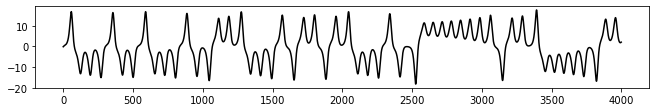

In [66]:
trainlen = 2000
future = 2000
plt.figure(figsize=(11,1.5))
plt.plot(range(0,trainlen+future),data[:trainlen+future],'k',label="target system")

Text(0.5, 1.0, 'A sample of data of lorentz')

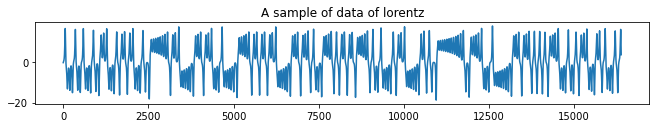

In [67]:
plt.figure(figsize=(11,1.5))
plt.plot(data[:])
plt.title('A sample of data of lorentz')

In [68]:
def train_test_split(data, k=20):
    '''
        Args:
            data : original data read from files (N,)
            k    : steps for ahead forecasting
        Returns: 
            io_pair ((N-1,2)) : input-output pair of whole data
            train_pair ((N-k-1,2)) : input-output training pair  
            test_pair ((k,2)) : input-output test pair
        
    '''
    io_pair = np.zeros((len(data) - 1, 2), dtype=float)

    for i in range(len(data) - 1):
        io_pair[i, 0] = data[i]
        io_pair[i, 1] = data[i + 1]
        
    split = io_pair.shape[0] - k
    train_pair = io_pair[:split, :]
    test_pair = io_pair[split:, :]
    
    return io_pair, train_pair, test_pair

### Initliaze randomized weights

- Elements of **$W^i$** is independently drawn from a uniform distribution in [−1, 1]
- Elements of **$W^r$** directly impacts on the “dynamics” of the network and therefore requires more:
    - uniformly in [-1, 1]
    - $W^r = a\frac{W_r}{p(W^r)}$ where $p(W^r)$ is the spectral radius of $W^r$ and **a** is a scalar hyper-parameter.

In [69]:
def initialize_weights(input_dim, a, n_reservoirs):
    '''
        Args:
            input_dim   : input dimensions
            a           : scalar - hyper-parameter
            n_reservoirs: number of reservoir neurons
        Returns:
            W_in: input-to-recurrent layer weights
            W_r: recurrent layer weights
    '''
    
    W_in = (np.random.rand(n_reservoirs, input_dim) - 0.5) * 1
    W_r = np.random.rand(n_reservoirs, n_reservoirs) - 0.5
    
    # compute the spectral radius of these weights
    spectral_radius = max(abs(np.linalg.eig(W_r)[0]))
    
    # rescale W_r
    W_r = (W_r*a)/spectral_radius
    
    return W_in, W_r

### Metrics for evaluating prediction performance

* Mean-squared error (MSE)

$$
MSE = 〈||t-z||^2〉
$$

    where〈·〉indicates average over time, t and z are target and predicted values, respectively.


In [70]:
def MSE(target, predicted):
    '''
    Args:
        target: target values
        predicted: predicted values
    Returns:
        loss of the model
    '''
    return np.square(np.subtract(target,predicted)).mean()

### Implement ESN network

#### Standard ESN model:

$x^t = \phi(W^r x_{t-1} + W^i u_t)$         

$z_t = W^o x_t$                             

- where $W^r$ and $W^i$ are randomly initialized, and $W^o$ is obtained as a solution to a (regularized) least-square problem

    - $W^r \in R^{N_r x N_r}$, where $N_r$ is the number of neurons in the recurrent layer (reservoir)
    - $W^i \in R^{N_r x N_i}$ is the input-to-reservoir weight matrix, $N_i$ is the input dimension
    - $W^o \in R^{N_o x N_r}$ is the read-output weight matrix, $N_o$ is the output dimension 
    - Activation function $\phi(x)$, I will use in this project is the **tanh** activation function 
    
    - **NOTE**: In this project, **N_o** and **N_i** is equal to 1 since we are dealing with ***unidimensional*** dataset



- The state $x_t$ can be seen as a vector of **temporal features**

- The sequence of states $x_t, t = 1,..., N$ is the **representation learned** by the ESN of the driving input $u_t$, $t = 1,...,N$

#### Ridge regression for the read-out weights

- Regularized least-square problem for $W_o$: 

    arg min $\frac{1}{2}||XW - t||^2 + \frac{\lambda}{2}||W||^2$ where $\lambda >= 0$ is the *regularization parameter*
    
    
- The closed form solution for the above problem is:

    $W^o = (X^TX + \lambda I)^{-1}X^Tt$ where **I** is an $N_r x N_r$ identity matrix
    
    - $W^o$ should be **transposed** before further use in the model
    
    
- Assume a supervised task (such as forecasting) and dataset $\{u_i, t_i\}^N_{i=1}$

Steps for **batch training**:
1. Initialize all model parameters $W^i$, $W^r$
2. Initialize the first state as $x_0 = 0$
3. Feed the network with the sequence of inputs $u_i$, i = 1, ...,N
4. Collect the resulting N states $x_i$ in a matrix $X \in R^{N x N_r}$
5. Store all related targets in a N-dimensional vector $t \in R^N$
6. Find $W^o$ by solving a regularized least-square problem

In [92]:
def ESN_train(training_pair, n_reservoirs=200, a=0.95, lamda=0.01):
    '''
        Args:
            training_pair ((N,2)) : training input-output pair  where N is number of training pairs
            n_reservoirs          : number of reservoir neurons
            a                     : scalar - hyper-parameter used for initialize recurrent weights 
            lamda                 : hyper-parameter used in ridge regression for read-out weights
        Returns:
            W_in
            W_r
            W_out ((, N_r))       : read-output weight matrix
    '''
    n_inputs = training_pair.shape[0]
    
    # initialize all model weights/parameters
    # Note: I hardcoded the input dimension (= 1) here
    #       since the input data set is unidimensional.
    W_i, W_r = initialize_weights(1, a, n_reservoirs) 
    
    # initialize the first state
    x = np.zeros((n_reservoirs, 1))
    
    # initlize holder for collecting N states x_i in a matrix X 
    X = np.zeros((n_inputs, n_reservoirs))
    
    # Feed the network with sequence of inputs u_i
    # and collect the resulting N states x_i in a matrix X.
    for i in range(n_inputs):
        u = np.array(train_pair[i, 0]) # inputs
        x = np.tanh(np.dot(W_r, x) + np.dot(W_i, u))  
        X[i, :] = x.squeeze()
    
    # Store all targeted values for those training inputs in a N-dimensional vector
    t = np.array(training_pair[:, 1])
    t = np.expand_dims(t, axis=0)
    
    # calculating W_o
    X = X.T
    W_o = np.linalg.solve(np.dot(X, X.T), np.dot(X, t.T)).T # temporary - without regularization term
    
    return x, W_i, W_r, W_o

In [93]:
data = read_file("lorenz.txt")
iopair, training_pair, testing_pair = train_test_split(data, k=20)
current_state, W_i, W_r, W_o = ESN_train(training_pair)

In [73]:
print(W_o)

[[ 4.22342963e+00  7.94469594e+00 -1.83858738e-01 -2.07565071e+00
   2.78532291e+00  5.08661636e+00 -1.98730525e+00 -6.02301271e+00
  -1.82189323e+00 -7.74777219e+00 -2.76467218e+00  4.12543550e+00
  -8.24544106e+00  8.08968476e-01 -1.00237902e+01 -1.34270161e+01
  -2.50541670e+00 -7.14191565e+00  5.54263852e+00  1.99297496e-01
  -1.15735765e+01 -3.86243072e+00  7.48863886e-01 -1.17822583e+01
   9.66423244e+00 -4.51510723e+00  5.09599914e+00  3.27723080e+00
   4.81529460e+00  8.57003987e+00 -3.58839854e+00 -2.40023299e+00
   1.42035414e+01  2.23193381e+00  5.69120355e+00 -1.33651181e+01
  -3.30582326e+00 -2.10232364e+00  6.71238145e-01 -6.79483878e+00
   5.81653290e+00 -1.80623040e+00 -1.18820108e+01  9.29872626e+00
  -1.01603141e+01 -7.60970620e+00  2.27122147e+00 -4.81797963e+00
  -9.07369800e-01  7.62417516e+00  8.17971177e+00  1.45553818e+00
   2.58689199e+00  2.40530809e+00  6.83333614e+00 -1.64701079e-01
   3.83604452e+00 -6.61349474e+00  1.10421017e+01  7.38512263e+00
  -8.29838

In [109]:
def ESN_k_step_predict(test_pair, x, W_in, W_r, W_out, k=20):
    '''
        Args:
            training_pair    : training input-output pair ((N,2)) where N is number of training pairs
            x                : current state after finish training
            W_in
            W_r
            W_out ((1, N_r)) : optimized read-output weight matrix
            k                : steps for ahead forecasting (hyperparameter)
        Returns:
            
    '''
    
    # intialize holder for predicted time series
    predicted_values = np.zeros((1,k)) 
    
    # get the input time value
    u = np.array(test_pair[0,0])
    
    for t in range(test_pair.shape[0]):
        x = np.tanh(np.dot(W_in,u) + np.dot(W_r,x))
        z = np.dot(W_out, x)
        predicted_values[:,t] = z
        u = z

    targeted_values = np.expand_dims(test_pair[:,1], axis=0)

    loss = MSE(targeted_values, predicted_values)
    
    return loss, targeted_values, predicted_values
    

In [110]:
Y = np.zeros((1,20))
Y

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [111]:
np.array(training_pair[-1,1])

array(15.119361)

In [112]:
training_pair[-1,1]

15.119361

In [113]:
t = testing_pair[:, 1]
t = np.expand_dims(t, axis=0)
t

array([[15.649582, 16.05312 , 16.306936, 16.392811, 16.299339, 16.023375,
        15.570592, 14.955072, 14.19797 , 13.325512, 12.366673, 11.350908,
        10.306204,  9.257641,  8.2265  ,  7.229871,  6.280668,  5.387925,
         4.557258,  3.791413]])

In [114]:
np.expand_dims(testing_pair[:,1], axis=0)

array([[15.649582, 16.05312 , 16.306936, 16.392811, 16.299339, 16.023375,
        15.570592, 14.955072, 14.19797 , 13.325512, 12.366673, 11.350908,
        10.306204,  9.257641,  8.2265  ,  7.229871,  6.280668,  5.387925,
         4.557258,  3.791413]])

In [117]:
loss, targets, predicts = ESN_k_step_predict(testing_pair, current_state, W_i, W_r, W_o)

In [118]:
loss

0.0018781299692374402

In [121]:
targets

array([[15.649582, 16.05312 , 16.306936, 16.392811, 16.299339, 16.023375,
        15.570592, 14.955072, 14.19797 , 13.325512, 12.366673, 11.350908,
        10.306204,  9.257641,  8.2265  ,  7.229871,  6.280668,  5.387925,
         4.557258,  3.791413]])

In [122]:
predicts

array([[15.64861403, 16.05071558, 16.30395219, 16.39155127, 16.3030063 ,
        16.03487622, 15.59113389, 14.98335547, 14.23088854, 13.36041014,
        12.40354426, 11.39212818, 10.3537779 ,  9.31129992,  8.28478687,
         7.29189619,  6.3459628 ,  5.45562071,  4.62645598,  3.86066702]])

### Plot Functions

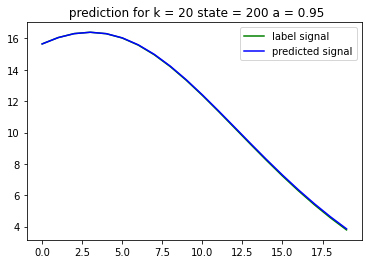

In [130]:
k = 20
a = 0.95
reservoir = 200
plt.figure(11).clear()
plt.plot( targets.T, 'g' )
plt.plot( predicts.T, 'b' )
plt.title(' prediction for k = ' + str(k) + " state = " +str(reservoir) + " a = " + str(a))
plt.legend(['label signal', 'predicted signal'])

### Experiments